In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# -------------------------------
# Define Kolmogorov-Arnold Layer
# -------------------------------
class KANLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(KANLayer, self).__init__()

        # Weight matrix: connects inputs -> outputs
        self.weight = nn.Parameter(torch.randn(out_features, in_features))

        # Bias vector for each output unit
        self.bias = nn.Parameter(torch.zeros(out_features))

        # Polynomial coefficients (KAN nonlinearity approximation)
        # For simplicity, let’s approximate using degree-3 polynomial
        self.poly_coef = nn.Parameter(torch.randn(out_features, 4))
        # shape = [out_features, degree+1]

    def forward(self, x):
        # (1) Apply linear transformation
        z = F.linear(x, self.weight, self.bias)
        # z shape = [batch_size, out_features]

        # (2) Build polynomial features [1, z, z^2, z^3]
        poly_terms = torch.stack([z**i for i in range(4)], dim=-1)
        # shape = [batch_size, out_features, 4]

        # (3) Multiply with learnable polynomial coefficients
        poly_out = torch.sum(self.poly_coef.unsqueeze(0) * poly_terms, dim=-1)
        # shape = [batch_size, out_features]

        return poly_out

In [3]:
# -------------------------------
# Define tiny KAN network
# -------------------------------
class TinyKAN(nn.Module):
    def __init__(self):
        super(TinyKAN, self).__init__()
        self.layer1 = KANLayer(1, 2)  # input=1, hidden=2
        self.layer2 = KANLayer(2, 1)  # hidden=2, output=1

    def forward(self, x):
        x = self.layer1(x)  # pass through first KAN layer
        x = torch.tanh(x)   # nonlinearity
        x = self.layer2(x)  # pass through second KAN layer
        return x


# -------------------------------
# Create dataset: y = sin(x)
# -------------------------------
x_train = np.linspace(-np.pi, np.pi, 50)
y_train = np.sin(x_train)

# Convert to torch tensors
x_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)  # [50,1]
y_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # [50,1]

In [4]:
# -------------------------------
# Instantiate model, loss, optimizer
# -------------------------------
model = TinyKAN()
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# -------------------------------
# Training loop (very short, 200 epochs)
# -------------------------------
for epoch in range(200):
    # Forward pass
    pred = model(x_tensor)

    # Compute loss
    loss = loss_fn(pred, y_tensor)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print occasionally
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.4f}")

Epoch 0, Loss = 525.0259
Epoch 50, Loss = 2.1487
Epoch 100, Loss = 1.1235
Epoch 150, Loss = 0.8743


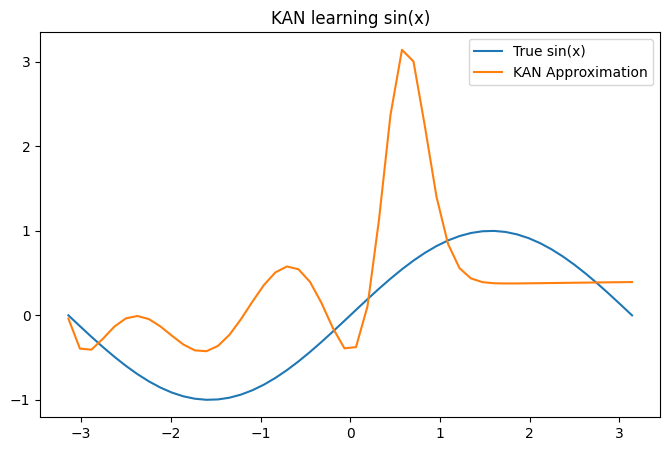

In [5]:
# -------------------------------
# Evaluate and plot
# -------------------------------
with torch.no_grad():
    y_pred = model(x_tensor).numpy()

plt.figure(figsize=(8,5))
plt.plot(x_train, y_train, label="True sin(x)")
plt.plot(x_train, y_pred, label="KAN Approximation")
plt.legend()
plt.title("KAN learning sin(x)")
plt.show()
